In [1]:
from compoundeye.evaluation import evaluate

import numpy as np
import matplotlib.pyplot as plt

ImportError: No module named compoundeye.evaluation

In [ ]:
%matplotlib inline
from environment import Sky
from compoundeye.geometry import fibonacci_sphere

samples = 1000

theta, phi = fibonacci_sphere(samples, 180)
sky = Sky(np.pi/6, np.pi)
y, p, a = sky(theta, phi)

plt.figure("Fig2", figsize=(3, 3))
ax = plt.subplot(131, polar=True)
es = ax.scatter(phi, theta, s=10, marker='.', c=y, cmap="Blues_r", vmin=-0., vmax=7.)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0, np.deg2rad(90)])
ax.title("Luminance")
plt.yticks([])
plt.xticks([])

ax = plt.subplot(132, polar=True)
es = ax.scatter(phi, theta, s=10, marker='.', c=p, cmap="Greys", vmin=0, vmax=1)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0, np.deg2rad(90)])
ax.title("Degree of polarisation (DOP)")
plt.yticks([])
plt.xticks([])

ax = plt.subplot(111, polar=True)
es = ax.scatter(phi, theta, s=10, marker='.', c=a, cmap="hsv", vmin=-np.pi, vmax=np.pi)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0, np.deg2rad(90)])
ax.title("Angle of polarisation (AOP)")
plt.yticks([])
plt.xticks([])

plt.show()

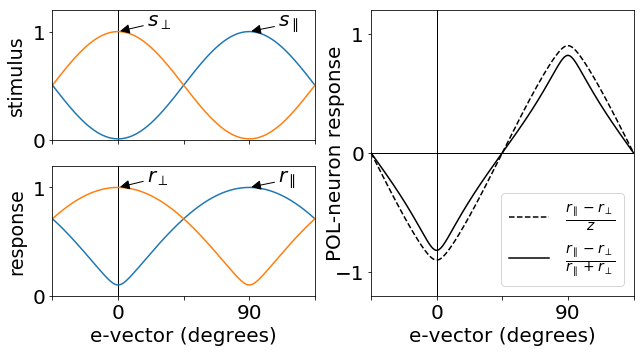

In [2]:
%matplotlib inline
from notebooks.plots import plot_pol_neurons_rotating_linear_polariser

Y = 15.  # light intensity
pol = .9  # degree of polarasation
e = np.linspace(-np.pi / 4, 3 * np.pi / 4, 361)  # e-vector orientation
act_func = np.sqrt  # activation function

# light perceived by the opponent photo-receptors
s_1 = Y * (np.square(np.cos(e)) + np.square(np.sin(e)) * np.square(1. - pol))
s_2 = Y * (np.square(np.sin(e)) + np.square(np.cos(e)) * np.square(1. - pol))

# transformation to the response of the photo-receptors
r_1 = act_func(s_1)
r_2 = act_func(s_2)

# POL-neuron response estimated by other models
z = act_func(Y)  # artificial normalisation factor
r_z = (r_2 - r_1) / z

# POL-neuron response estimated by our model with natural normalisation factor
r_pol = (r_2 - r_1) / (r_2 + r_1)

# show input, latent representation and output of POL-neurons
plot_pol_neurons_rotating_linear_polariser(
    [np.rad2deg(e), s_1 / Y], [np.rad2deg(e), s_2 / Y],
    [np.rad2deg(e), r_1 / z], [np.rad2deg(e), r_2 / z],
    [np.rad2deg(e), r_z], [np.rad2deg(e), r_pol]).show()